<a href="https://colab.research.google.com/github/rohit78u/Matrix-Calculator/blob/main/FDS_Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()  # Select sale_price.csv and customer_feedback.json


Saving customer_feedback.json to customer_feedback.json
Saving sale_price.csv to sale_price.csv


/tmp/ipython-input-2798900683.py:27: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sales_df['sale_date'] = pd.to_datetime(sales_df['sale_date'], errors='coerce')


[ETL] Processed data saved to data_warehouse/processed_sales_data.csv


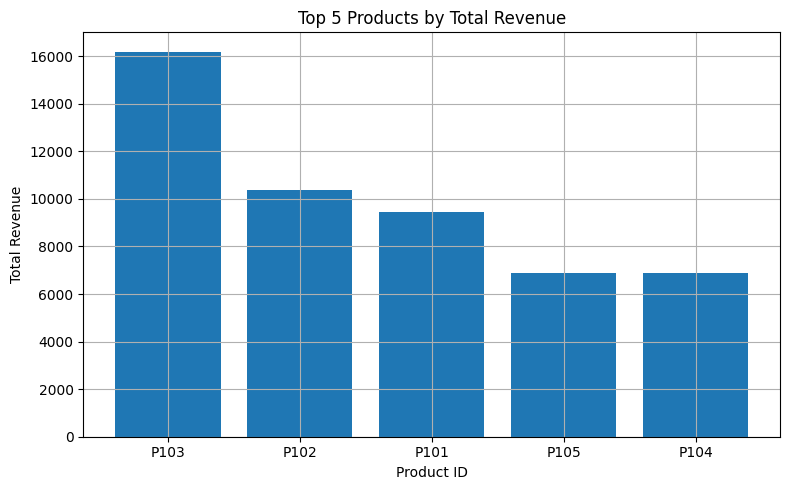

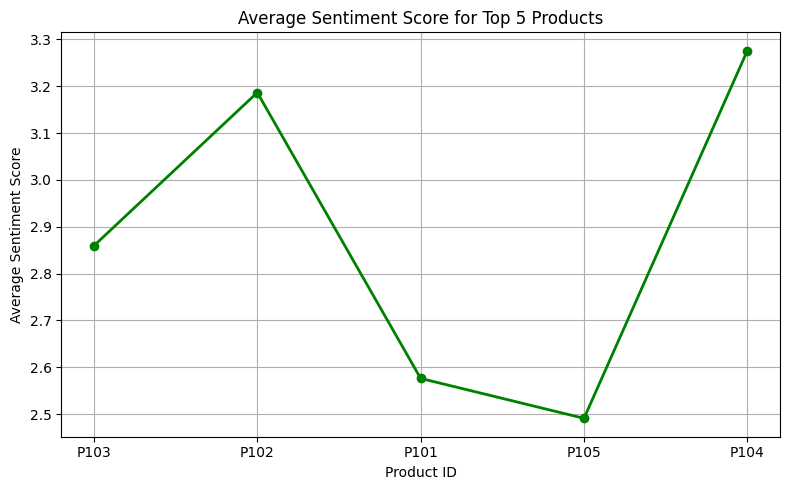


--- Feedback to Data Engineer ---
Some sale_date entries couldn't be parsed. Please ensure date consistency.

--- Final Report ---
  product_id  total_revenue  avg_sentiment
0       P103        16194.0       2.859574
1       P102        10389.0       3.186667
2       P101         9447.0       2.576190
3       P105         6894.0       2.490909
4       P104         6871.5       3.276000
[ML] VIP classification completed. File saved to data_warehouse/enriched_sales_with_VIP.csv
   sale_id product_id customer_id  sale_price  quantity  sale_date  \
0     1001       P101       C_001       150.0         2 2023-01-15   
1     1002       P102       C_002        75.0         3        NaT   
2     1003       P103       C_001       250.5         1 2023-01-25   
3     1004       P101       C_003       150.0         4 2023-02-01   
4     1005       P104       C_004        30.0         1 2023-02-05   

   total_revenue VIP_status  
0          300.0    Non-VIP  
1          225.0    Non-VIP  
2      

In [15]:
# -------------------------------
# Lab 2: Full ETL + DA + VIP Classification Pipeline
# -------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# -------------------------------
# Stage 1 & 2: Data Engineer - ETL
# -------------------------------

# Ensure data warehouse folder
os.makedirs("data_warehouse", exist_ok=True)

# Ingestion
sales_df = pd.read_csv("sale_price.csv")  # Upload in Colab before running
feedback_df = pd.read_json("customer_feedback.json")

# Cleansing
sales_df['sale_price'] = sales_df['sale_price'].replace('[\$,]', '', regex=True).astype(float)
sales_df['quantity'] = sales_df['quantity'].fillna(1).astype(int)

sales_df['sale_date'] = pd.to_datetime(sales_df['sale_date'], errors='coerce')
feedback_df['review_date'] = pd.to_datetime(feedback_df['review_date'], errors='coerce')

# Transformation
sales_df['total_revenue'] = sales_df['sale_price'] * sales_df['quantity']

feedback_df = feedback_df.sort_values('review_date').drop_duplicates(
    subset=['product_id', 'customer_id'], keep='last'
)

merged_df = pd.merge(sales_df, feedback_df, on=['product_id', 'customer_id'], how='left')
merged_df = merged_df[(merged_df['sale_price'] > 0) & (merged_df['review_date'].notna())]

# Loading
processed_path = "data_warehouse/processed_sales_data.csv"
merged_df.to_csv(processed_path, index=False)
print(f"[ETL] Processed data saved to {processed_path}")

# -------------------------------
# Stage 3: Data Analyst - Analysis
# -------------------------------

df = pd.read_csv(processed_path)

# Top 5 products by revenue
top_products = (
    df.groupby('product_id')['total_revenue']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)

# Average sentiment for top products
avg_sentiment = (
    df.groupby('product_id')['sentiment_score']
    .mean()
    .reset_index()
    .rename(columns={'sentiment_score': 'avg_sentiment'})
)

# Merge for report
report_df = pd.merge(top_products, avg_sentiment, on='product_id', how='left')

# Plot 1: Revenue
plt.figure(figsize=(8, 5))
plt.bar(report_df['product_id'], report_df['total_revenue'])
plt.title('Top 5 Products by Total Revenue')
plt.xlabel('Product ID')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Sentiment
plt.figure(figsize=(8, 5))
plt.plot(report_df['product_id'], report_df['avg_sentiment'], color='green', marker='o', linewidth=2)
plt.title('Average Sentiment Score for Top 5 Products')
plt.xlabel('Product ID')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n--- Feedback to Data Engineer ---")
if df['sentiment_score'].isnull().sum() > 0:
    print("Some sentiment scores are missing. Consider collecting more feedback data.")
if df['sale_date'].isnull().sum() > 0:
    print("Some sale_date entries couldn't be parsed. Please ensure date consistency.")

print("\n--- Final Report ---")
print(report_df)

# -------------------------------
# Stage 5: ML Engineer - VIP Classification + Reverse ETL
# -------------------------------

# Feature engineering for customers
customer_stats = (
    sales_df.groupby('customer_id')
    .agg(
        total_purchase_amount=('sale_price', 'sum'),
        purchase_frequency=('sale_date', 'count'),
        avg_transaction_value=('sale_price', 'mean')
    )
    .reset_index()
)

# Fill missing
customer_stats = customer_stats.fillna(0)

# Normalize
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(
    customer_stats[['total_purchase_amount', 'purchase_frequency', 'avg_transaction_value']]
)

# K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
customer_stats['cluster'] = kmeans.fit_predict(scaled_features)

# Identify VIP cluster
vip_cluster = customer_stats.groupby('cluster')['total_purchase_amount'].mean().idxmax()
customer_stats['VIP_status'] = np.where(customer_stats['cluster'] == vip_cluster, 'VIP', 'Non-VIP')

# Merge VIP status back to sales
enriched_sales = pd.merge(sales_df, customer_stats[['customer_id', 'VIP_status']], on='customer_id', how='left')

# Save enriched dataset
vip_output_path = "data_warehouse/enriched_sales_with_VIP.csv"
enriched_sales.to_csv(vip_output_path, index=False)
print(f"[ML] VIP classification completed. File saved to {vip_output_path}")

# Show sample
print(enriched_sales.head())
